# Introduction to Convolutional Neural Networks

CSC/DSC 340 Week 10 Slides

Author: [Dr. Julie Butler](www.juliebutler.org)

Date Created: October 21, 2023

Last Modified: October 21, 2023

## Introduction and Termoinology

* This week we will cover convolutional neural networks (CNNs)
    * Image analysis, video analysis, object detection
* Note that we will not be going through any mathematics this week as the mathematics of CNNs is quite complicated but there are many good resources (including your textbook) if you are interested

* Convolution refers to the mathematical combination of two functions to produce a third function
    * It merges two sets of information
    * The convolution is performed on the input data with the use of a filter or kernel (these terms are used interchangeably) to then produce a feature map.

![CNNs](https://cdn-media-1.freecodecamp.org/images/Htskzls1pGp98-X2mHmVy9tCj0cYXkiCrQ4t)

[Image Source](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)

## Introduction to the MNIST Data Set
* Photos (28 pixels by 28 pixels) of handwritten numeric digits as the input
* Number shown in the photo as an output
* Challenges: 2D data structure (images), variations in handwriting, low quality images, size of data set (60,000 images in the training set, 10,000 in the test set)

### Import With Tensorflow
* Also avaliable through Scikit-Learn, but does not come automatically split into a training and test set

In [1]:
import tensorflow as tf

# Load MNIST data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

# Print the shape of the data
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


* Let's display some of the images

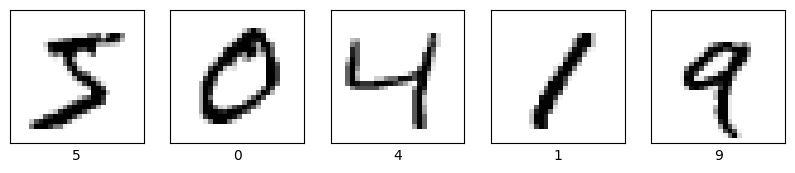

In [2]:
import matplotlib.pyplot as plt
# Display a small number of images
num_images = 5
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

* 60k is a lot of images to have in a training set (though may be needed for large neural networks)
* Let's randomly select 5k images to use for training instead of 60k so networks train faster
* Can use a smaller data set in the construction of your neural network (hyperparameter tuning process) but then use a larger sample to train the final network

In [3]:
import numpy as np
random_indices = np.random.choice(60000, 5000, replace=False)
train_images_smaller = train_images[random_indices]
train_labels_smaller = train_labels[random_indices]

* Classification can suffer from class imbalances. Let's make sure our data is relatively evenly distributed.

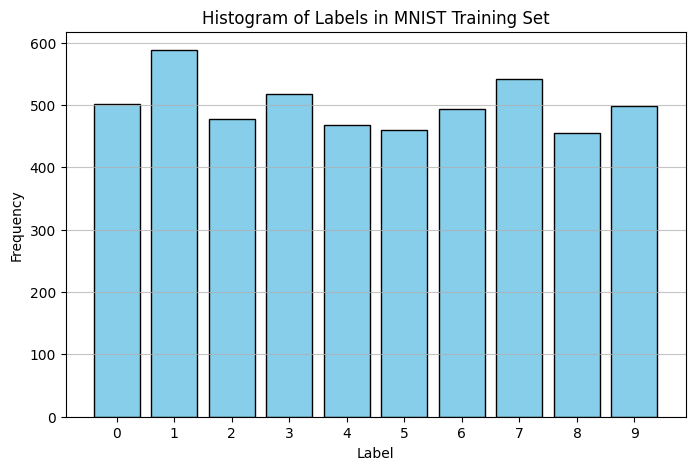

In [4]:
# Create a histogram of the labels
plt.figure(figsize=(8, 5))
plt.hist(train_labels_smaller, bins=range(11), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Histogram of Labels in MNIST Training Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.grid(axis='y', alpha=0.75)
plt.show()

## Classification with a Regular Neural Network
* We can clasify the MNIST data with a regular neural network, but due to its architecture we have to flatten the data before it can reach the dense layers
* Neural networks can be used to successfully classify images, but flattening the images can remove important patterns

* Create a model that flattens the data (28x28 pixel images). We then have one hidden layer with 128 neurons and a Relu activation function, and an output layer with 10 neurons (10 possible outputs) and a softmax activation function since this is a classification.

In [5]:
from tensorflow.keras import layers, models
# Build the model
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

* For compiling the model we will use the Adam optimizer, our metric of success will be accuracy, and our loss function is sparse categorical cross-entropy
    * Sparse categorical cross-entropy is similiar to categorical cross-entropy but while categorical cross-entropy requires the data to be one-hot encoded prior to training the model, sparse categorical cross-entropy does not

In [6]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

* Train the model and the determine the accuracy

In [7]:
# Train the model
model.fit(train_images, train_labels, epochs=5, verbose=1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2511 - accuracy: 0.9281
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1125 - accuracy: 0.9667
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0773 - accuracy: 0.9765
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0578 - accuracy: 0.9823
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0446 - accuracy: 0.9861
313/313 - 1s - loss: 0.0857 - accuracy: 0.9737 - 889ms/epoch - 3ms/step

Test accuracy: 0.9736999869346619


* When we perform classification without one-hot encoding, the outputs of the model are not the class labels, but rather the probability that the input belongs to each class

In [8]:
# Predict the test set
y_pred = model.predict(test_images)
print(y_pred[0])

313/313 [==============================] - 1s 3ms/step
[1.09134476e-07 5.39056728e-08 4.72913689e-06 6.48848654e-05
 9.03134078e-12 1.28101090e-06 1.20599342e-12 9.99916553e-01
 9.35825824e-07 1.14619170e-05]


* Before performing further anaysis on our neural network outputs, we need to convert the data from probabilities to the actual class label

In [9]:
# Predict the test set
y_pred = np.argmax(model.predict(test_images), axis=-1)

print(y_pred[0])

313/313 [==============================] - 1s 3ms/step
7


* Now let's create a confusion matrix to see which points are being misclassified

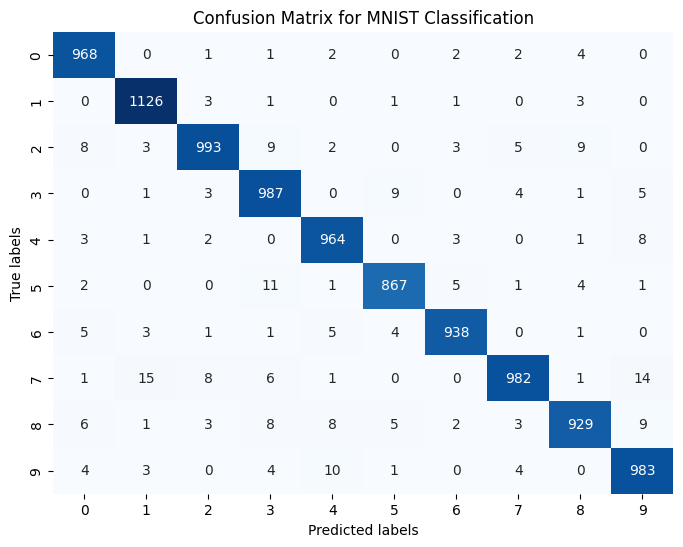

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for MNIST Classification')
plt.show()

## Classification with a Convolutional Neural Network



### Types of Layers and Keras Syntax

* Conv2D
    * [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
    * The first number is the number of filters (dimensionality of the output)
    * The tuple is the stride (the width and height of the section of pixels to be reduced down)
    * Activation has the same function here as in regular neural networks
    * Convolutional layers apply learnable filters to the data that creates a feature map to a higher or lower dimensional space
    * Used to detect important features and patterns in the data
* MaxPooling2D
    * [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D)
    * Tuple is the pool size (the size block over which to find the maximum)
    * Pooling layers reduce the dimensionality of the data while keeping the most important features
    * Two types of pooling layers: max pooling and average pooling
* Stacking convolutional and pooling layers allows CNNS to learn in a heirarchical manner
    * First the networks learns basic featutes of the data (like edges and textures) and then more complicated features
    * This heirarchical learning is what makes CNNS so effective at image analysis
* Note that not every convolutional layer has to be followed by a pooling layer, too many pooling layers can be bad

### Full Neural Network for Classification
* Have two pairs of convolutional layers/pooling layers of different sizes followed by a lone convolutional layer
* The `Flatten()` layer is needed to take the 2D data down to one dimension for the dense layers
* The first dense layer (a hidden layer) does some post-processing on the data that comes from the CNN layers, the second dense layer is the output layer

In [11]:
# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

* Model is compiled, trained, and tested in the same way as the regular neural network

In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
844/844 [==============================] - 36s 42ms/step - loss: 0.1895 - accuracy: 0.9423 - val_loss: 0.0558 - val_accuracy: 0.9830
Epoch 2/5
844/844 [==============================] - 34s 41ms/step - loss: 0.0539 - accuracy: 0.9830 - val_loss: 0.0380 - val_accuracy: 0.9878
Epoch 3/5
844/844 [==============================] - 33s 40ms/step - loss: 0.0375 - accuracy: 0.9883 - val_loss: 0.0320 - val_accuracy: 0.9903
Epoch 4/5
844/844 [==============================] - 24s 29ms/step - loss: 0.0288 - accuracy: 0.9907 - val_loss: 0.0360 - val_accuracy: 0.9902
Epoch 5/5
844/844 [==============================] - 17s 21ms/step - loss: 0.0243 - accuracy: 0.9920 - val_loss: 0.0349 - val_accuracy: 0.9902
313/313 - 1s - loss: 0.0369 - accuracy: 0.9891 - 1s/epoch - 4ms/step

Test accuracy: 0.9890999794006348


313/313 [==============================] - 1s 4ms/step


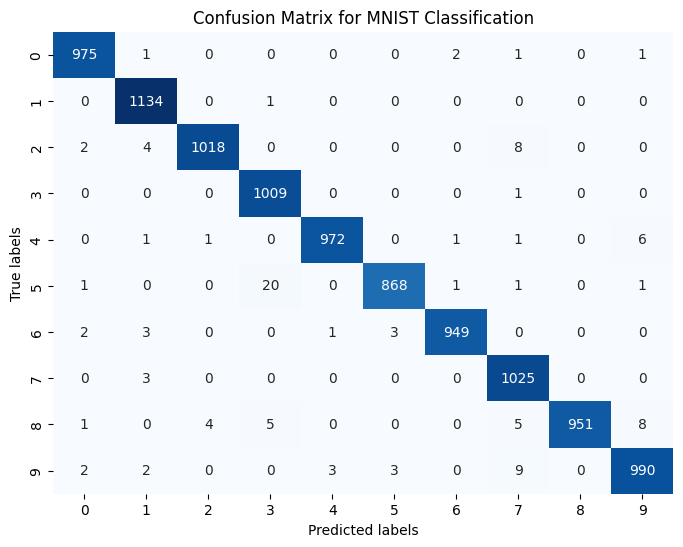

In [14]:
# Predict the test set
y_pred = np.argmax(model.predict(test_images), axis=-1)

# Create confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for MNIST Classification')
plt.show()

## Hyperparameter Tuning for Convolutional Neural Networks

* You can use the same strategies learned for tuning regular neural networks
* First, reduce the number of layers

In [15]:
# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
844/844 [==============================] - 7s 8ms/step - loss: 0.2286 - accuracy: 0.9323 - val_loss: 0.0831 - val_accuracy: 0.9780
Epoch 2/5
844/844 [==============================] - 7s 9ms/step - loss: 0.0740 - accuracy: 0.9781 - val_loss: 0.0658 - val_accuracy: 0.9823
Epoch 3/5
844/844 [==============================] - 7s 9ms/step - loss: 0.0500 - accuracy: 0.9850 - val_loss: 0.0613 - val_accuracy: 0.9817
Epoch 4/5
844/844 [==============================] - 7s 9ms/step - loss: 0.0380 - accuracy: 0.9884 - val_loss: 0.0544 - val_accuracy: 0.9847
Epoch 5/5
844/844 [==============================] - 8s 9ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.0522 - val_accuracy: 0.9872
313/313 - 0s - loss: 0.0443 - accuracy: 0.9861 - 417ms/epoch - 1ms/step

Test accuracy: 0.9861000180244446


* Remove the post-processing Dense layer

In [16]:
# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
844/844 [==============================] - 16s 19ms/step - loss: 0.1937 - accuracy: 0.9404 - val_loss: 0.0603 - val_accuracy: 0.9838
Epoch 2/5
844/844 [==============================] - 18s 21ms/step - loss: 0.0571 - accuracy: 0.9822 - val_loss: 0.0502 - val_accuracy: 0.9843
Epoch 3/5
844/844 [==============================] - 17s 20ms/step - loss: 0.0388 - accuracy: 0.9875 - val_loss: 0.0350 - val_accuracy: 0.9903
Epoch 4/5
844/844 [==============================] - 17s 20ms/step - loss: 0.0309 - accuracy: 0.9903 - val_loss: 0.0359 - val_accuracy: 0.9907
Epoch 5/5
844/844 [==============================] - 16s 19ms/step - loss: 0.0240 - accuracy: 0.9925 - val_loss: 0.0351 - val_accuracy: 0.9910
313/313 - 1s - loss: 0.0283 - accuracy: 0.9919 - 1s/epoch - 3ms/step

Test accuracy: 0.9919000267982483


* Have more filters in the convolutional layers

In [17]:
# Build the model
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
844/844 [==============================] - 42s 50ms/step - loss: 0.1557 - accuracy: 0.9517 - val_loss: 0.0495 - val_accuracy: 0.9835
Epoch 2/5
844/844 [==============================] - 40s 48ms/step - loss: 0.0441 - accuracy: 0.9860 - val_loss: 0.0405 - val_accuracy: 0.9887
Epoch 3/5
844/844 [==============================] - 41s 49ms/step - loss: 0.0315 - accuracy: 0.9904 - val_loss: 0.0467 - val_accuracy: 0.9850
Epoch 4/5
844/844 [==============================] - 42s 50ms/step - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.0350 - val_accuracy: 0.9892
Epoch 5/5
844/844 [==============================] - 57s 67ms/step - loss: 0.0178 - accuracy: 0.9942 - val_loss: 0.0279 - val_accuracy: 0.9925
313/313 - 3s - loss: 0.0258 - accuracy: 0.9913 - 3s/epoch - 10ms/step

Test accuracy: 0.9912999868392944


* Add an extra pooling layer

In [18]:
# Build the model
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
844/844 [==============================] - 17s 19ms/step - loss: 0.2846 - accuracy: 0.9132 - val_loss: 0.0936 - val_accuracy: 0.9725
Epoch 2/5
844/844 [==============================] - 19s 23ms/step - loss: 0.0905 - accuracy: 0.9717 - val_loss: 0.0706 - val_accuracy: 0.9782
Epoch 3/5
844/844 [==============================] - 16s 19ms/step - loss: 0.0678 - accuracy: 0.9789 - val_loss: 0.0559 - val_accuracy: 0.9857
Epoch 4/5
844/844 [==============================] - 18s 21ms/step - loss: 0.0510 - accuracy: 0.9840 - val_loss: 0.0545 - val_accuracy: 0.9847
Epoch 5/5
844/844 [==============================] - 19s 22ms/step - loss: 0.0423 - accuracy: 0.9865 - val_loss: 0.0732 - val_accuracy: 0.9795
313/313 - 1s - loss: 0.0792 - accuracy: 0.9759 - 1s/epoch - 3ms/step

Test accuracy: 0.9758999943733215


* Remove some pooling layers

In [ ]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
844/844 [==============================] - 41s 49ms/step - loss: 0.1689 - accuracy: 0.9474 - val_loss: 0.0542 - val_accuracy: 0.9855
Epoch 2/5
844/844 [==============================] - 47s 56ms/step - loss: 0.0477 - accuracy: 0.9851 - val_loss: 0.0436 - val_accuracy: 0.9897
Epoch 3/5
154/844 [====>.........................] - ETA: 34s - loss: 0.0348 - accuracy: 0.9891

## A Few Warnings
* Because of the downsampling/dimensionality reduction performed by the convolutional and pooling layers, you can reduce the information passed onto the next layer to nothing (`ValueError`)
* Tips to fix these errors:
    * Reduce the number of layers, especially the number of pooling layers
    * Reduce the pool size (minimum is (2,2))
    * Use the `padding="same"` for the Conv2D layers
* These networks can take a very long time to train, especially with many filters, many layers, or a large amount of data